In [140]:
import numpy as np
from dataclasses import dataclass, field
from typing import Callable
from numpy.typing import NDArray
from opt_einsum import contract

Let's define the required matrices, Pauli-Z, fermionic creation, and annihilation operators.
$$Z = \begin{pmatrix} 
1 & 0 \\ 0 & -1
\end{pmatrix}, c^{\dagger} = \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}, c = \begin{pmatrix}0 & 1 \\ 0 & 0\end{pmatrix}$$

In [141]:
Z = np.array([[1, 0], [0, -1]], dtype=complex)
creation_operator = np.array([[0, 0], [1, 0]], dtype=complex)
annihilation_operator = np.array([[0, 1], [0, 0]], dtype=complex)

Let's confirm the antisymmetry for the fermionic operators, namely for vacuum states $\Psi_0$ and occupied states $\Psi$ -
$$c^{\dagger}\Psi_0 = \Psi$$ 
$$c \Psi = \Psi_0$$ 
$$c^\dagger \Psi = 0$$ 
$$c \Psi_0 = 0$$ 
$$c^\dagger c + c c^\dagger = I$$

In [142]:
# Antisymmetry Confirmations for Fermionic Operators 
vacuum_state = np.array([1, 0])
occupied_state = np.array([0, 1])

# c† |0> = |1>
assert((creation_operator @ vacuum_state == occupied_state).all())

# c† |0> = NULL
assert((creation_operator @ occupied_state == np.zeros(2,)).all())

# c |1> = |0>
assert((annihilation_operator @ occupied_state == vacuum_state).all())

# c† |0> = NULL
assert((annihilation_operator @ vacuum_state == np.zeros(2,)).all())

# c†c + cc† = I
assert((annihilation_operator @ creation_operator + creation_operator @ annihilation_operator == np.eye(2)).all())

The above defined matrices are for single-fermion Hilbert space. To extend it to n-fermion Hilbert space in the Fock Basis, we'll construct a Jordan-Wigner string to map fermionic operators to spin operators.
$$c^{\dagger}_j = Z_0 \otimes Z_1 \otimes \cdots Z_{j-1} \otimes c^{\dagger} \otimes I_{i+1} \otimes \cdots I_{N-1}$$ 
$$c_j = Z_0 \otimes Z_1 \otimes \cdots Z_{j-1} \otimes c \otimes I_{i+1} \otimes \cdots I_{N-1}$$ 

In [143]:
import functools

def creation_gate(i, N):
    ops = []

    for j in range(N):
        if j < i:
            ops.append(Z)
        elif j == i:
            ops.append(creation_operator)
        else: 
            ops.append(np.eye(2))
    
    return functools.reduce(np.kron, ops)

def annihilation_gate(i, N): 
    ops = []

    for j in range(N):
        if j < i:
            ops.append(Z)
        elif j == i:
            ops.append(annihilation_operator)
        else: 
            ops.append(np.eye(2))
    
    return functools.reduce(np.kron, ops)

We'll be building Kitaev Chains in multiple bases. Let's build an abstract class to define its core features - 

In [144]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt 

@dataclass
class KitaevChain(ABC): 
    N: int
    mu: Callable[[float], float]
    Delta: Callable[[float], float]
    h: Callable[[float], float]
    t0: float
    hamiltonian: NDArray = field(init=False)
    state_vector : NDArray = field(init=False)

    @abstractmethod
    def __post_init__():
        pass

    @abstractmethod
    def evolve(t): 
        pass

    def vis(self, tol=1e-6): 
        eigvals, eigvecs = np.linalg.eigh(self.hamiltonian)

        zero_indices = np.where(np.abs(eigvals) < tol)[0]
        
        if len(zero_indices) == 0:
            print("No zero modes found.")
            return

        print("Zero mode indices:", zero_indices)
        print("Zero mode energies:", eigvals[zero_indices])

        # Prepare heatmap data
        heatmap_data = np.zeros((len(zero_indices), self.N))

        for row, idx in enumerate(zero_indices):
            vec = eigvecs[:, idx]
            vec /= np.linalg.norm(vec)  # Normalize just in case

            for site in range(self.N):
                mask = 1 << site
                for basis_index in range(len(vec)):
                    if basis_index & mask:
                        heatmap_data[row, site] += np.abs(vec[basis_index])**2

        # Plot using matplotlib's imshow
        plt.figure(figsize=(10, 2 + 0.3 * len(zero_indices)))
        plt.imshow(heatmap_data, aspect='auto', cmap='inferno', origin='lower')
        plt.colorbar(label='Occupation Probability')
        plt.xticks(ticks=np.arange(self.N), labels=np.arange(self.N))
        plt.yticks(ticks=np.arange(len(zero_indices)), labels=[f'Mode {i}' for i in zero_indices])
        plt.xlabel("Site Index")
        plt.ylabel("Zero Mode Index")
        plt.title("Zero Mode Localization Heatmap")
        plt.tight_layout()
        plt.show()

Let's build the Fock Basis Hamiltonian - 
$$\hat H_c = -\mu \sum_{j=1}^N \left ( c_j^{\dagger}c_j - \frac12 \right ) - t\sum_{j=1}^{N-1} (c_j^{\dagger}c_{j+1} + c_{j+1}^\dagger c_j) + |\Delta| \sum_{j=1}^{N-1} (c_jc_{j+1} + c^{\dagger}_{j+1} c_j^{\dagger})$$ 

In [145]:
@dataclass 
class KitaevChainFock(KitaevChain): 
    creations: NDArray = field(init=False)
    annihilations: NDArray = field(init=False)
    chemical_potential_term: NDArray = field(init=False)
    hopping_term: NDArray = field(init=False)
    pairing_term: NDArray = field(init=False)

    def __post_init__(self):
        # Create and store creation and annihilation operators for each fermionic mode
        self.creations = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)
        self.annihilations = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)

        for i in range(self.N): 
            self.creations[i] = (creation_gate(i, self.N))
            self.annihilations[i] = (annihilation_gate(i, self.N))

        self.chemical_potential_term = np.zeros((2**self.N, 2**self.N), dtype=complex) 
        self.hopping_term = np.zeros_like(self.chemical_potential_term)
        self.pairing_term = np.zeros_like(self.chemical_potential_term)

        for i in range(self.N-1):
            self.hopping_term += self.creations[i] @ self.annihilations[i+1] + self.creations[i+1] @ self.annihilations[i]
            self.pairing_term += self.annihilations[i] @ self.annihilations[i+1] + self.creations[i+1] @ self.creations[i]

            self.chemical_potential_term += self.creations[i] @ self.annihilations[i] - 0.5 * np.eye(2**self.N)

        self.chemical_potential_term += self.creations[self.N - 1] @ self.annihilations[self.N - 1] - 0.5 * np.eye(2**self.N) 


        self.hamiltonian = (
            -self.mu(self.t0) * (self.chemical_potential_term - (self.N/2) * np.eye(2**self.N))
            - self.h(self.t0) * self.hopping_term 
            + self.Delta(self.t0) * self.pairing_term
            )

        self.state_vector = np.zeros(2**self.N,)
        self.state_vector[0] = 1

    def evolve(self, t): 
        pass

 Let's switch to Majorana operators, which are defined as linear combinations of the fermionic creation and annihilation operators.

$$\gamma_{j}^\alpha = c_j + c_j^{\dagger}$$
$$\gamma_{j}^\beta = i(c_j^\dagger - c_j)$$ 
These operators are Hermitian and anticommute - 
$$\gamma_j^\alpha = {\gamma_j^\alpha}^\dagger$$ 
$$\gamma_i^\alpha\gamma_j^\beta = 2\delta_{ij}\delta_{\alpha \beta}$$
Using this, the Kitaev Hamiltonian in the Majorana basis becomes 
$$\hat H_\gamma = -\frac{i\mu}{2} \sum_{j=1}^N \gamma_j^\beta\gamma_j^\alpha + \frac{i}{2}\sum_{j=1}^{N-1}(\omega_{+} \gamma_j^\beta \gamma_{j+1}^\alpha + \omega_{-}\gamma_{j+1}^\beta\gamma_j^\alpha)$$ 
where $\omega_{\pm} = t \pm \Delta$. As $|\Delta| \to 0$, we enter the trivial phase, where Majorana operators are coupled. As $\mu \to 0$ and $|\Delta| \to t$, our Hamiltonian becomes $$\hat H_\gamma = it \sum_{j=1}^{N-1} \gamma_j^\beta \gamma_{j+1}^\alpha$$
In other words, every Majorana operator is coupled to a different type of operator at a different site. If we reintroduce fermionic creation and annihilation operators as $$\tilde{c}_j = \frac12 (\gamma_j^\beta + i \gamma_j^\alpha)$$ 
our Hamiltonian becomes 
$$\hat H_{\tilde{c}} = 2t \sum_{j=1}^{N-1}\left (\tilde{c}_j^\dagger\tilde{c}_j + \frac12 \right )$$
which gives us $N-1$ nodes. The last node is the topologically-protected Majorana Zero Mode (MZM). Because it is a zero mode, it doesn't require any energy and does not appear in the Hamiltonian expression. The Majorana zero mode is given by the following linear combination of Majorana operators - 
$$c^* = \frac12 (\gamma_{N}^\beta + i\gamma_1^\alpha)$$
As you can see, the first and last sites of the chain are involved. This means that the mode is highly delocalized. It is this delocalization that provides topological protection against local perturbations, making the MZM the most promising type of qubit for fault-tolerant quantum computing. 

In [146]:
@dataclass
class KitaevChainMajorana(KitaevChain): 
    alpha_majoranas: NDArray = field(init=False)
    beta_majoranas: NDArray = field(init=False)
    chemical_potential_term: NDArray = field(init=False)
    hopping_term: NDArray = field(init=False)
    pairing_term: NDArray = field(init=False)

    def __post_init__(self):
        creations = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)
        annihilations = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)

        for i in range(self.N): 
            creations[i] = (creation_gate(i, self.N))
            annihilations[i] = (annihilation_gate(i, self.N))

        self.alpha_majoranas = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)
        self.beta_majoranas = np.zeros((self.N, 2**self.N, 2**self.N), dtype=complex)

        for i in range(self.N): 
            self.alpha_majoranas[i] = creations[i] + annihilations[i]
            self.beta_majoranas[i] = 1j * (creations[i] - annihilations[i])
        
        self.chemical_potential_term = np.zeros((2**self.N, 2**self.N), dtype=complex)
        self.hopping_term = np.zeros((2**self.N, 2**self.N), dtype=complex)
        self.pairing_term = np.zeros((2**self.N, 2**self.N), dtype=complex)

        for j in range(self.N - 1):
            self.hopping_term +=  self.beta_majoranas[j] @ self.alpha_majoranas[j+1]
            self.pairing_term +=  self.beta_majoranas[j+1] @ self.alpha_majoranas[j]

        for j in range(self.N):
            self.chemical_potential_term += self.beta_majoranas[j] @ self.alpha_majoranas[j]

        self.hamiltonian = (
            0.5j * (-self.mu(self.t0) * self.chemical_potential_term
                    + (self.h(self.t0) + self.Delta(self.t0)) * self.hopping_term 
                    + (self.h(self.t0) - self.Delta(self.t0)) * self.pairing_term)
        )

    def evolve(self, t):
        pass

In [163]:
mu = lambda t: 0 
t = lambda t: 1
Delta = lambda t: 0.8

fock_chain = KitaevChainFock(
    N=10,
    mu=mu,
    h=t,
    Delta=Delta,
    t0=2
)

majorana_chain = KitaevChainMajorana( 
    N=10,
    mu=mu, 
    h=t, 
    Delta=Delta,
    t0=2
)

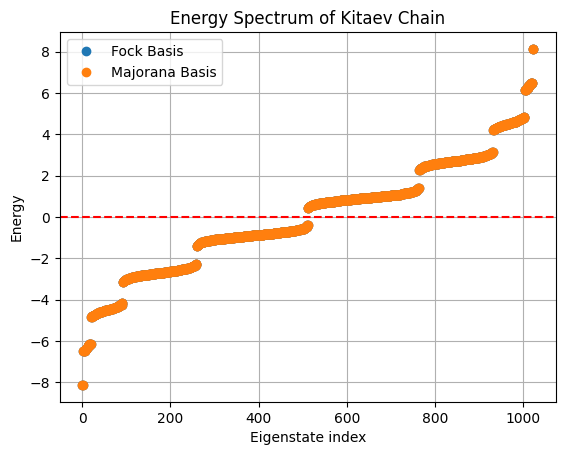

In [168]:
fock_eigvals = np.linalg.eigvalsh(fock_chain.hamiltonian)
majorana_eigvals = np.linalg.eigvalsh(majorana_chain.hamiltonian)
plt.plot(fock_eigvals, 'o', label='Fock Basis')
plt.plot(majorana_eigvals, 'o', label="Majorana Basis")
plt.axhline(0, color='r', linestyle='--')
plt.title("Energy Spectrum of Kitaev Chain")
plt.xlabel("Eigenstate index")
plt.ylabel("Energy")
plt.grid(True)
plt.legend()
plt.show()